In [7]:
# For an explanation of Portfolio Optimization, See: https://www.youtube.com/watch?v=Rz5tGZdyViw

# Systematic risk: cannot be diversified away 

# Idiosynchratic risk: specific to an asset: can bve diversified away
# Two data extraction options are compared
# 1.- Quandl
# 2.- Data_Reader

%matplotlib inline 
%timeit
# import needed modules
import quandl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
plt.style.use('fivethirtyeight')

stockStartDate = '2014-1-1'
today = datetime.today().strftime('%Y-%m-%d')

In [8]:
# Avoid Warnings
import warnings
warnings.filterwarnings("ignore")

In [30]:
# 2.- Get the Adjusted closing prices of 5 selected danish companies with DataReader
# NVO: Novo Nordisk A/S
# DANSKE.CO : Danske Bank A/S
# NZYM-B.CO : Novozymes A/S
# CARL-B.CO : Carlsberg A/S
# ORSTED.CO : Oersted A/S
import pandas_datareader as web

selected = ['NVO', 'DANSKE.CO', 'NZYM-B.CO', 'CARL-B.CO', 'ORSTED.CO']
table = pd.DataFrame()

for stock in selected:
    table[stock] = web.DataReader(stock, 'yahoo', start = stockStartDate, end = today)['Adj Close']

In [31]:
table.columns.values

array(['NVO', 'DANSKE.CO', 'NZYM-B.CO', 'CARL-B.CO', 'ORSTED.CO'],
      dtype=object)

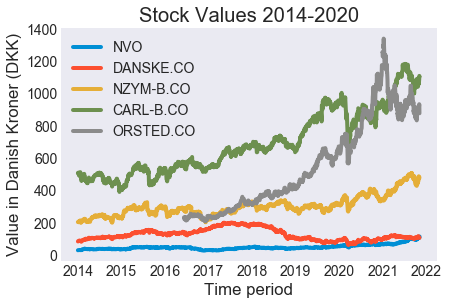

In [32]:
# show the downloaded values
for stock in table.columns.values:
    plt.plot(table[stock], label=stock)
plt.title('Stock Values 2014-2020')
plt.xlabel('Time period')
plt.ylabel('Value in Danish Kroner (DKK)')
plt.legend()
plt.show()

In [33]:
table

,NVO,DANSKE.CO,NZYM-B.CO,CARL-B.CO,ORSTED.CO
Date,,,,,
2014-01-02,31.099449,85.762291,205.573792,507.849518,NaN
2014-01-03,31.516123,85.762291,205.929016,509.131012,NaN
2014-01-06,31.428043,87.488571,205.840179,507.849518,NaN
2014-01-07,31.854874,88.800568,204.419418,511.266541,NaN
2014-01-08,32.071674,89.629181,206.373001,502.724121,NaN
...,...,...,...,...,...
2021-10-29,110.129997,108.900002,473.200012,1061.500000,908.000000
2021-11-01,109.440002,108.449997,475.500000,1089.500000,934.000000
2021-11-02,110.050003,107.900002,481.000000,1109.000000,927.799988


In [34]:
# calculate daily and annual returns of the stocks
returns_daily = table.pct_change()
returns_annual = returns_daily.mean() * 250

# get daily and covariance of returns of the stock
cov_daily = returns_daily.cov()
cov_annual = cov_daily * 250

#variance

print('Annual Returns: ', returns_annual.map('{:,.2%}'.format))
print('***************************************************')
print('Annual Covariance: ', cov_annual.applymap('{:,.2%}'.format))

Annual Returns:  NVO          19.76%
DANSKE.CO     6.61%
NZYM-B.CO    13.92%
CARL-B.CO    12.15%
ORSTED.CO    27.84%
dtype: object
***************************************************
Annual Covariance:               NVO DANSKE.CO NZYM-B.CO CARL-B.CO ORSTED.CO
NVO        6.18%     1.11%     1.62%     1.33%     1.50%
DANSKE.CO  1.11%     7.46%     1.63%     1.78%     1.27%
NZYM-B.CO  1.62%     1.63%     6.23%     1.45%     1.48%
CARL-B.CO  1.33%     1.78%     1.45%     4.63%     1.71%
ORSTED.CO  1.50%     1.27%     1.48%     1.71%     7.27%


In [35]:
var_annual = returns_daily.var()*250
vol_annual = np.sqrt(var_annual)
print('Annual Variability:')
print(var_annual.map('{:,.2%}'.format))
print('**************************')
print('Annual VOlatility:')
print(vol_annual.map('{:,.2%}'.format))

Annual Variability:
NVO          6.18%
DANSKE.CO    7.46%
NZYM-B.CO    6.23%
CARL-B.CO    4.63%
ORSTED.CO    7.27%
dtype: object
**************************
Annual VOlatility:
NVO          24.87%
DANSKE.CO    27.31%
NZYM-B.CO    24.96%
CARL-B.CO    21.52%
ORSTED.CO    26.96%
dtype: object


In [48]:
# empty lists to store returns, volatility and weights of imiginary portfolios
port_returns = []
port_volatility = []
sharpe_ratio = []
stock_weights = []

# set the number of combinations for imaginary portfolios
num_assets = len(selected)
num_portfolios = 200000

#set random seed for reproduction's sake
np.random.seed(101)

# populate the empty lists with each portfolios returns,risk and weights
for single_portfolio in range(num_portfolios):
    weights = np.random.random(num_assets)
    weights /= np.sum(weights)
    returns = np.dot(weights, returns_annual)
    volatility = np.sqrt(np.dot(weights.T, np.dot(cov_annual, weights)))
    sharpe = returns / volatility
    sharpe_ratio.append(sharpe)
    port_returns.append(returns)
    port_volatility.append(volatility)
    stock_weights.append(weights)

In [49]:
# a dictionary for Returns and Risk values of each portfolio
portfolio = {'Returns': port_returns,
             'Volatility': port_volatility,
             'Sharpe Ratio': sharpe_ratio}

# extend original dictionary to accomodate each ticker and weight in the portfolio
for counter,symbol in enumerate(selected):
    portfolio[symbol+' Weight'] = [Weight[counter] for Weight in stock_weights]

# make a nice dataframe of the extended dictionary
df = pd.DataFrame(portfolio)

# get better labels for desired arrangement of columns
column_order = ['Returns', 'Volatility', 'Sharpe Ratio'] + [stock+' Weight' for stock in selected]

# reorder dataframe columns
df = df[column_order]

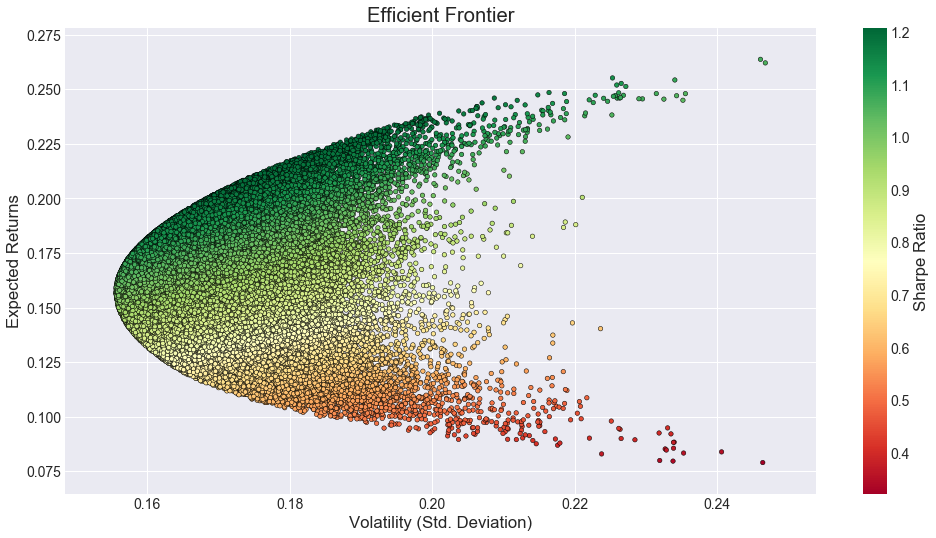

In [50]:
# plot frontier, max sharpe & min Volatility values with a scatterplot
plt.style.use('seaborn-dark')
df.plot.scatter(x='Volatility', y='Returns', c='Sharpe Ratio',
                cmap='RdYlGn', edgecolors='black', figsize=(15, 8), grid=True)
plt.xlabel('Volatility (Std. Deviation)')
plt.ylabel('Expected Returns')
plt.title('Efficient Frontier')
plt.show()

In [51]:
type(stock_weights)

list

In [52]:
type(sharpe_ratio)

list

In [53]:
sharpe_ratio.index(max(sharpe_ratio))

106181

In [54]:
print('The optimum porfolio configuration is:')
print('NVO  | DANSKE.CO | NZYM-B.CO | CARL-B.CO | CHEMM.CO')
print([ "{:0.2%}".format(x) for x in stock_weights[sharpe_ratio.index(max(sharpe_ratio))]])
print('Which is where the sharp ratio is maximum with a value of: ', max(sharpe_ratio))

The optimum porfolio configuration is:
NVO  | DANSKE.CO | NZYM-B.CO | CARL-B.CO | CHEMM.CO
['31.69%', '0.05%', '11.06%', '9.47%', '47.73%']
Which is where the sharp ratio is maximum with a value of:  1.2089153456501824


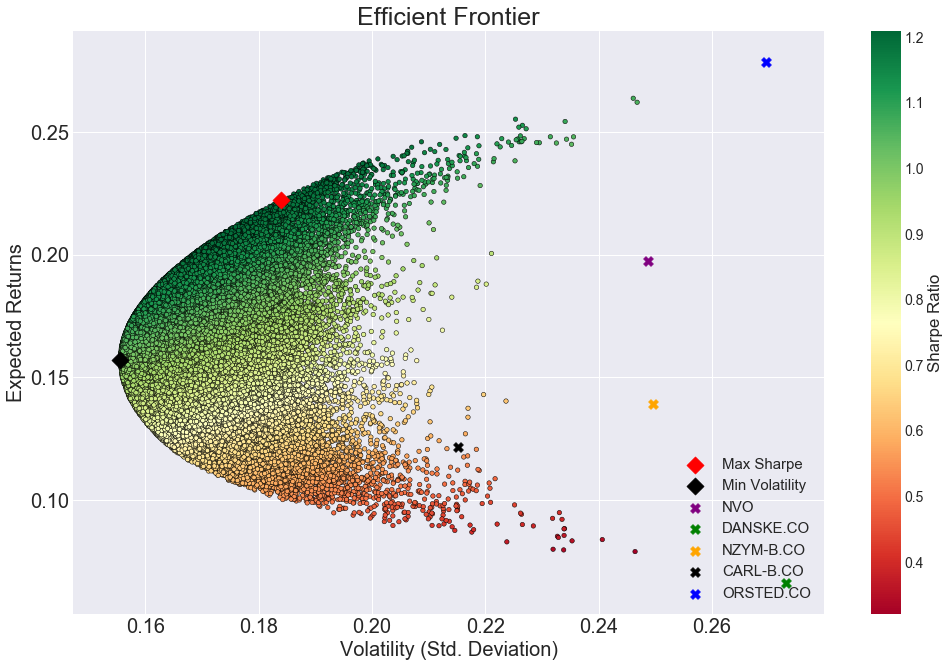

In [55]:
# plot frontier, max sharpe & min Volatility values with a scatterplot
plt.style.use('seaborn-dark')
df.plot.scatter(x='Volatility', y='Returns', c='Sharpe Ratio',
                cmap='RdYlGn', edgecolors='black', figsize=(15, 10), 
                grid=True, fontsize=20)
plt.scatter(df['Volatility'][sharpe_ratio.index(max(sharpe_ratio))],
            df['Returns'][sharpe_ratio.index(max(sharpe_ratio))], 
            marker = 'D', color ='red', s =150, label = 'Max Sharpe')
plt.scatter(df['Volatility'][port_volatility.index(min(port_volatility))],
            df['Returns'][port_volatility.index(min(port_volatility))], 
            marker = 'D', color ='black', s =150, label = 'Min Volatility')
color_list = ['purple', 'green','orange', 'black','blue']
for i in range(0,len(table.columns.values)):
    plt.scatter(vol_annual[i], returns_annual[i], 
                marker = 'X', color = color_list[i], 
                s=100, label = table.columns.values[i])
plt.xlabel('Volatility (Std. Deviation)', fontsize =20)
plt.ylabel('Expected Returns', fontsize=20)
plt.title('Efficient Frontier', fontsize=25)
plt.legend(loc='lower right', fontsize=15)
plt.show()

In [56]:
print('Maximum Sharpe Ratio')
print('**********************')
print('Random Profolio Num.', df[df['Sharpe Ratio']==max(sharpe_ratio)].index[0])
print(df.iloc[[sharpe_ratio.index(max(sharpe_ratio))]].
      T.applymap('{:,.2%}'.format).to_string(header=False))

Maximum Sharpe Ratio
**********************
Random Profolio Num. 106181
Returns            22.24%
Volatility         18.40%
Sharpe Ratio      120.89%
NVO Weight         31.69%
DANSKE.CO Weight    0.05%
NZYM-B.CO Weight   11.06%
CARL-B.CO Weight    9.47%
ORSTED.CO Weight   47.73%


In [57]:
print('Minimum Volatility')
print('Random Profolio Num.', df[df['Volatility']==min(port_volatility)].index[0])
print('**********************')
print(df.iloc[[port_volatility.index(min(port_volatility))]].
      T.applymap('{:,.2%}'.format).to_string(header=False))

Minimum Volatility
Random Profolio Num. 173824
**********************
Returns            15.70%
Volatility         15.56%
Sharpe Ratio      100.93%
NVO Weight         20.51%
DANSKE.CO Weight   15.55%
NZYM-B.CO Weight   19.18%
CARL-B.CO Weight   28.73%
ORSTED.CO Weight   16.03%


## Two ways of obtaining the same results

In [58]:
print(df.iloc[[sharpe_ratio.index(max(sharpe_ratio))]].T.applymap('{:,.2%}'.format).to_string(header=False))
            

Returns            22.24%
Volatility         18.40%
Sharpe Ratio      120.89%
NVO Weight         31.69%
DANSKE.CO Weight    0.05%
NZYM-B.CO Weight   11.06%
CARL-B.CO Weight    9.47%
ORSTED.CO Weight   47.73%


In [59]:

print(df[df['Sharpe Ratio']==max(sharpe_ratio)].T.applymap('{:,.2%}'.format).to_string(header=False))

Returns            22.24%
Volatility         18.40%
Sharpe Ratio      120.89%
NVO Weight         31.69%
DANSKE.CO Weight    0.05%
NZYM-B.CO Weight   11.06%
CARL-B.CO Weight    9.47%
ORSTED.CO Weight   47.73%
